# Why aren't NSIDC sea ice concentration grids analysis ready?

## Introduction

Analysis Ready Data (ARD) is a hot topic within the earth science community and beyond.  As yet, there is no clear definition.  Chris Holmes of Planet Labs [defines](https://medium.com/planet-stories/analysis-ready-data-defined-5694f6f48815#:~:text=Analysis%20Ready%20Data%20are%20time,in%20preparing%20imagery%20for%20analysis.) ARD as time series stacks of remotely sensed images that have been processed so that users can analyze the data without any pre-processing.  In a remote sensing context, this includes atmospheric corrections, georectification, projection and resampling to a common grid.  These are time consuming tasks.  CEOS (Committee on Earth Observation Satellites) has a similar but perhaps less strict definition that ARD are satellite data that have been processed to a minimum set of requirements and organized into a form that allows immediate analysis with a minimum of effort.

Although this definition contains some aspects that might apply to other forms of earth science data, it is specific to remote sensing data and may not apply to model output or field observations.  A common task faced by researchers is combining data from different sources; for example passive microwave sea ice concentration with near-surface temperature from ERA5 reanalysis, and sea ice freeboard from ICESat-2.  _Maybe a different combination of data: ice motion vectors_.

Passive microwave sea ice concentration and ERA5 output could both be considered analysis ready.  Both data sets are on common (but different) grids that can be stacked into a time-series for analysis.  However, in the case of sea ice concentration there is some pain involved in doing this.  Here, I'm using the [NSIDC-0051](https://nsidc.org/data/nsidc-0051) daily sea ice concentration datset.  The daily grids are stored as binary files with a 300-byte header at the beginning of the file followed by the data.  The data grid combines concentration data and mask values, stored as scaled byte data.  The user guide contains a description of the data format but no example code to read the data.  Coordinate information are stored on separate grids that are not linked to directly from the user guide.  Data are also in a NSIDC specific polar stereographic projection, which is not equal-area.  Even though the grid is nominally 25 km x 25 km, grid areas are required to calculate aggregate statistics.

A first time user has to expend considerable time and effort to to write code to read the data before it can be used.  The steps involved in this process are:

1. Search for required data using the Earthdata search and generate a download script.  Because files are daily, downloading large numbers of files takes a long time.
2. Before files can be read, a user needs to scour the user guide for file format information.  This information includes length of header, format of header if you want the information contained in it, data type, grid dimensions, scale factor and mask values.
3. Write code to read the data using the following steps.  
    a. Open file.  
    b. Read the header and extract any information you need.  
    c. Read data.  
    d. Reshape the data (if your binary reader does not do this automatically).  
    e. Decide what to do about non-data cells that are masked; e.g. set these cells to NaN or some other no-data value.  
    f. Scale valid data.  
4. Organize data into some time-series structure to allow efficient analysis; for example a data-cube with dimensions time, x, y
5. If you want to plot the data on a map, regrid the data, or subset data by coordinates, you need to download or generate the coordinate information.
6. If you want to calculate any area statistics you also need to download the cell-areas.

I go through these steps below, with the exception of downloading data.  However, even by reading through these steps above, I hope it is clear that it is an effort to get the data into a sensible format before any analysis can be done.  I would argue that even though the sea ice concentration meets the criteria that it is ARD so far as it is in a common grid, the sorage format makes it no analysis ready.  A much better solution would be to have data stored in a self describing scientific data format such as netCDF, HDF5 or geoTIFF.  Ideally, daily grids could be combined into monthly or annual files.  These files would contain projected x and y, and time coordinates, along with latitude and longitude, and cell area grids.  My preferred format would be netCDF because it is a relatively simple format and handles multi-dimensional data.  NetCDF is also commonly used in earth science.  HDF5 is OK but often tends to have a more complicated file structure that requires tailor-made routines to read.  GeoTIFF is limited because it does not provide for 3-D data cubes.  Programming languages such as python, R, Matlab and IDL all have methods to read netCDF, HDF5 and geoTIFF.

### Useful links
[CEOS webinar](https://www.youtube.com/watch?v=YU3ZXOsH7DE&feature=emb_err_woyt)

## Reading the data - making $20 the hard way...
I use the `python` `numpy` package as an example but other high-level languages like `R`, `Matlab` and `IDL` have similar functions.  This code could be translated to those languages.  I've already downloaded a year of data for the northern hemisphere for 2009 as an example, so I skip the first two steps. In addition to `numpy`, I use the `datetime` package to handle image dates and `matplotlib` and `cartopy` to display the data.

_add `conda install` command to install cartopy and other packages._

In `python` the packages need to be imported before commands can be used.  This saves having to install a bunch of unnecessary routines.  It also serves as a way to organize functions.  For example, I use the expression `import numpy as np` which assigns the numpy package to the shorthand object `np`.  I can then call `numpy` functions using the syntax `np.arange()`, which generates a sequence of values.  If I imported another package `dumpy` with a similar function, I could call that function using `dumpy.arange()` without having any conflict.

The shorthand names, `np`, `dt`, `plt` for the packages are commonly used within the python community.

In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

### 1 Search for data

### 2 Gather file format information
NSIDC-0051 files are binary files that include a header.  To read a file, the data type and size of header, and the data type and shape of the data need to be known.  The structure of the header data also need to be known if you want to extract that data.  This is described in the [file format](https://nsidc.org/data/nsidc-0051#title7) section of the user guide.  Here, I use `numpy.fromfile` to read the file.  The header information is read first.  Then the image data is read.  The sea ice concentration dataset has different sized grids for north and south polar regions.  This adds another layer of complexity because any code to read these files requires information about the hemisphere or at least the shape of the grid.

Because this is an example, I focus on a northern hemipshere grid from 2009 and hard-code the grid shape.

In [2]:
file_path = '/home/apbarret/Data/seaice/nsidc-0051/nt_20090901_f17_v1.1_n.bin'
rows = 448
cols = 304
HEADER_LENGTH = 300
DATA_DTYPE = np.uint8

### 3 a-d and Read header and data
Steps 3 a, b, c and d are done in one step within a context block.  The context block avoids the need to close the file handle.  This is good practice.  The header is read with a simple read call to extract a 300-byte string.  The second call `np.fromfile` reads single byte unsigned integers and uses `reshape` to reshape these integers into a grid `(rows, cols)`. 

In [51]:
with open(file_path, "rb") as fp:
    header = fp.read(HEADER_LENGTH)
    data = np.fromfile(fp, dtype=DATA_DTYPE).reshape(rows, cols)

The header string is a sequence of bytes representing ASCII character strings.  For compatibility with ANSI C, IDL, and other languages, character strings are terminated with a NULL byte.

In [52]:
print(header)

b'00255\x00  304\x00  448\x001.799\x0039.43\x0045.00\x00558.4\x00154.0\x00234.0\x00SSMIS\x0017 cn\x00  244\x00-9999\x00-9999\x00  244\x00-9999\x00-9999\x00 2009\x00  244\x00  000\x0000250\x00  nt_20090901_f17_v01_n\x00ARCTIC    SSMISS TOTAL ICE CONCENTRATION       DMSP  F17     DAY 244 09/01/2009\x00ARCTIC     SSMISONSSMIGRID CON Coast253Pole251Land254      09/02/2014\x00'


The header has the following sections.

- 21-element array of 6-byte character strings that contain information such as polar stereographic grid characteristics
- 24-byte character string containing the file name
- 80-character string containing an optional image title
- 70-byte character string containing ancillary information such as data origin, data set creation date, etc.

Each element of the header and the width of each element is described in Table 2.

Table 2. File Header Description

| Byte | Description |
|------|------------|
| 1-6 | Missing data integer value |
| 7-12 | Number of columns in polar stereographic grid |
| 13-18 | Number of rows in polar stereographic grid |
| 19-24 | Unused/internal |
| 25-30 | Latitude enclosed by polar stereographic grid |
| 31-36 | Greenwich orientation of polar stereographic grid |
| 37-42 | Unused/internal |
| 43-48 | J-coordinate of the grid intersection at the pole |
| 49-54 | I-coordinate of the grid intersection at the pole |
| 55-60 | Five-character instrument descriptor (SMMR, SSM/I, SSMIS) |
| 61-66 | Two descriptors of two characters each that describe the data; (for example, 07 cn = Nimbus-7 ice concentration) |
| 67-72 | Starting Julian day of grid data |
| 73-78 | Starting hour of grid data (if available) |
| 79-84 | Starting minute of grid data (if available) |
| 85-90 | Ending Julian day of grid data |
| 91-96 | Ending hour of grid data (if available) |
| 97-102 | Ending minute of grid data (if available) |
| 103-108 | Year of grid data |
| 109-114 | Julian day of grid data |
| 115-120 | Three-digit channel descriptor (000 for ice concentrations) |
| 121-126 | Integer scaling factor |
| 127-150 | 24-character file name (without file-name extension) |
| 151-230 | 80-character image title |
| 231-300 | 70-character data information (creation date, data source, etc.) |

The header information can parsed into a `numpy` structured array using `np.frombuffer`.

In [53]:
# Define composite datatypes
NASATEAM_HEADER = [('missing_data', 'a6'),
                   ('grid_cols', 'a6'),
                   ('grid_rows', 'a6'),
                   ('unused1', 'a6'),
                   ('latitude_enclosed', 'a6'),
                   ('greenwich_orientation', 'a6'),
                   ('unused2', 'a6'),
                   ('pole_j', 'a6'),
                   ('pole_i', 'a6'),
                   ('instrument', 'a6'),
                   ('descriptors', 'a6'),
                   ('starting_day_of_year', 'a6'),
                   ('start_hour', 'a6'),
                   ('start_minute', 'a6'),
                   ('ending_day_of_year', 'a6'),
                   ('end_hour', 'a6'),
                   ('end_minute', 'a6'),
                   ('year', 'a6'),
                   ('julian_day', 'a6'),
                   ('channel_descriptor', 'a6'),
                   ('scale_factor', 'a6'),
                   ('filename', 'a24'),
                   ('image_title', 'a80'),
                   ('data_information', 'a70')]
header = np.frombuffer(header, dtype=np.dtype(NASATEAM_HEADER))
header['missing_data']  # Example selection of element

array([b'00255'], dtype='|S6')

These are all strings but the data can be extracted and cast into the appropriate data type.  For example, `missing_data` is an integer. 

In [54]:
header['missing_data'][0].astype(np.int)

255

The data are in `data`, stored as an image.  `matplotlib.pyplot.imshow` can be used to display the image.  We can add a colorbar to help interpret the values.  Values span from 0 to 254. 

Data range:  Min=0, Max=254


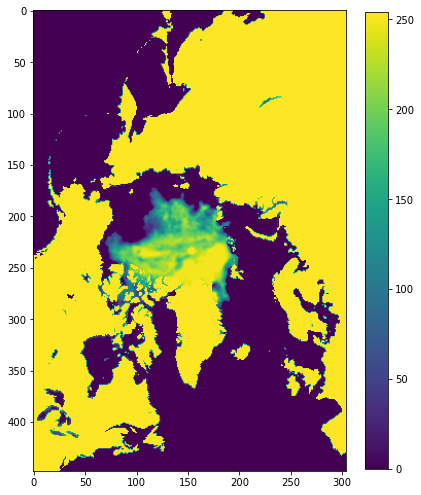

In [55]:
print(f"Data range:  Min={data.min()}, Max={data.max()}")
fig, ax = plt.subplots(figsize=(7,12))
img = ax.imshow(data)
plt.colorbar(img, ax=ax, shrink=0.7)

From the user guide, we know that the image is a combination of concentration values, which should span 0.0 to 1.0, or 0% to 100%, and mask values.  So we have to do some further processing to get an array of values that can be used for analysis.  From [Table 1](https://nsidc.org/data/nsidc-0051#title3) in the user guide, values greater than 0 and less than or equal to 250 are sea ice concentration, multiplied by 250.  Values greater than 250 are mask values.  The mask values might be useful so I will split the array into a sea ice concentration array `sic` and a `mask` array.  Values that were mask are set to NaN.

Scale Factor = 250.0


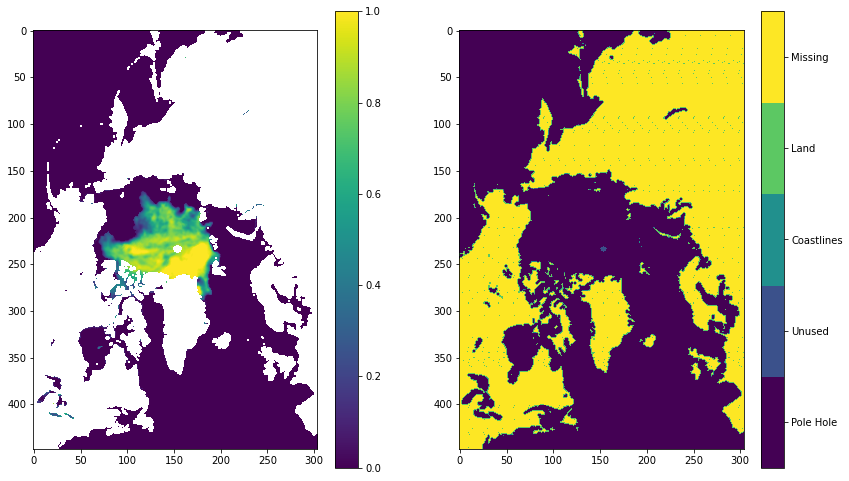

In [65]:
scale_factor = header['scale_factor'][0].astype(np.float)
print(f'Scale Factor = {scale_factor}')

sic = np.where(data <= 250, data/scale_factor, np.nan)
mask = np.where(data > 250, data, 0)

fig, ax = plt.subplots(1, 2, figsize=(14, 12))

# Plot the concentration data
img1 = ax[0].imshow(sic)
plt.colorbar(img1, ax=ax[0], shrink=0.7)

# Generate a discrete normalization
bounds = np.array([250, 251, 252, 253, 254, 255])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# Plot the mask
img2 = ax[1].imshow(mask, norm=norm)
cbar2 = fig.colorbar(img2, ax=ax[1], shrink=0.7, ticks=[250.5, 251.5, 252.5, 253.5, 254.5])
cbar2.ax.set_yticklabels(['Pole Hole', 'Unused', 'Coastlines', 'Land', 'Missing']);

Now we have data in a format we can analyze.  Although we can display the data as an image, it would be nice to display the data on a map.  This would allow other information or data sets to be displayed.  To do this we need coordinate information. Alternatively, we can supply projection and image extent to imshow.  I'll use `cartopy` and `matplotlib` to display the data.

First the coordinate data need to be loaded.  These coordinates can be latitude and longitude, or x and y coordinates in the NSIDC polar stereographic projection.  The latitude and longitude grids are included in the notebooks directory.  They can also be downloaded from the NSIDC [Polar Stereographic Tools site](https://nsidc.org/data/polar-stereo/tools_geo_pixel.html#psn25lats_v3.dat_pss25lats_v3.dat).

These data are scaled and need to be divided by 100000.  They also need to be reshaped.

In [89]:
NORTH_LATITUDE_FILE = 'psn25lats_v3.dat'
NORTH_LONGITUDE_FILE = 'psn25lons_v3.dat'
NORTH_AREA_FILE = 'psn25area_v3.dat'
psn25_lats = np.fromfile(NORTH_LATITUDE_FILE, dtype=np.int32).reshape(rows, cols) / 100000.
psn25_lons = np.fromfile(NORTH_LONGITUDE_FILE, dtype=np.int32).reshape(rows, cols) / 100000.
psn25_area = np.fromfile(NORTH_AREA_FILE, dtype=np.int32). reshape(rows, cols) / 1000.

As an example, the data are plotted on a north polar sterographic map.

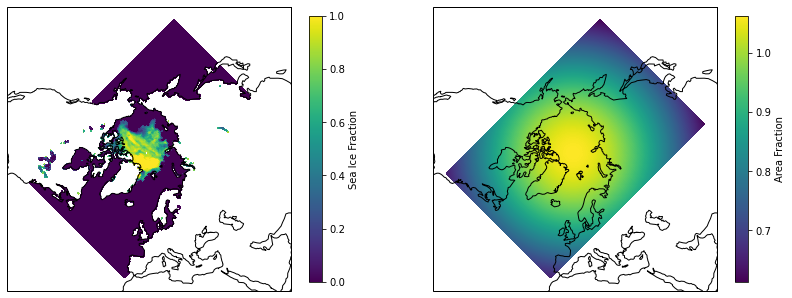

In [94]:
import cartopy.crs as ccrs

map_proj = ccrs.NorthPolarStereo()  # Use the default north polar stereographic projection for now
data_proj = ccrs.PlateCarree()  # Projection of coordinates - we use lat, lon in this example.

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121, projection=map_proj)
ax1.coastlines()
img = ax1.pcolormesh(psn25_lons, psn25_lats, sic, transform=data_proj)
fig.colorbar(img, shrink=0.7, label='Sea Ice Fraction')

ax2 = fig.add_subplot(122, projection=map_proj)
ax2.coastlines()
img2 = ax2.pcolormesh(psn25_lons, psn25_lats, psn25_area/(25.*25.), transform=data_proj)
fig.colorbar(img2, shrink=0.7, label='Area Fraction')


The data look the same but are rotated from the images displayed using `matplotlib.pyplot.imshow`.  This is because the NSIDC polar stereographic projection has a central longitude -45 E.  The NSIDC polar stereographic also uses a different latitude of true scale than many other north polar stereographic projections.  Map projections are mathematical transformations that attempt to _project_ the spherical or ellipsoidal Earth onto a plane.  All _projections_ distort the Earth in some way; either distorting angles (shape), area or distance over some portion of the map.  The polar stereographic projection preserves angles (it is conformal) but not distance or area, except at the tangent point or latitude of true scale.  To limit distortion over the Arctic region, the NSIDC polar stereographic projection sets the latitude of true scale to be 70 N.  Therefore, the length of an arc on the Earth surface is only true at 70 N.  At all other latitudes arc length is distorted.  This affects areas   

https://nsidc.org/data/polar-stereo/ps_grids.html  
https://en.wikipedia.org/wiki/Stereographic_projection

Projection parameters can be defined to match the NSIDC North Polar-Stereographic projection.  `projection_params` contains both projection and grid definitions.  A `'globe'` definition is also included because the North Polar-Stereographic projection is based on the Hughs-1980 ellipsoid.  Cartopy's projections default globe is WGS84.

In [110]:
projection_params = {
    'pixel_width': 25000,
    'pixel_height': -25000,
    'offset_x': -3850000.000,
    'offset_y': 5850000.000,
    'ccrs': {             # parameters passed to cartopy
        'central_latitude': 90.0,
        'central_longitude': -45.0,
        'false_easting': 0.0,
        'false_northing': 0.0,
        'true_scale_latitude': 70,
        },
    'globe': {
            'semimajor_axis': 6378273, 
            'semiminor_axis': 6356889.449,
        },
    'bounds': [-3850000.000, 3750000., -5350000., 5850000.000],
}

Projection parameters are passed to the `cartopy.crs.Stereographic` projection object.

In [111]:
projection = ccrs.Stereographic(**projection_params['ccrs'], globe=ccrs.Globe(**projection_params['globe']))

Below, I use `matplotlib.pyplot.imshow` to plot the sea ice concentration image.  The image is thresholded at 15% concentration.

/home/apbarret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


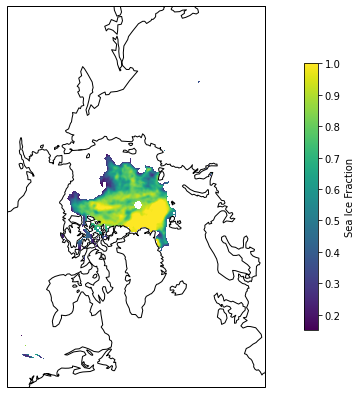

In [115]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(projection=projection)
ax.coastlines()
img = ax.imshow(np.where(sic > 0.15, sic, np.nan), extent=projection_params['bounds'], origin='upper')
#img = ax.pcolormesh(psn25_lons, psn25_lats, sic, transform=projection)
fig.colorbar(img, shrink=0.7, label='Sea Ice Fraction')

## An easier way

## Appendix

In [171]:
import os
import xarray as xr
from affine import Affine


rows = 448
cols = 304
HEADER_LENGTH = 300
DATA_DTYPE = np.uint8
DEFAULT_SEA_ICE_PATH = '/home/apbarret/Data/seaice/nsidc-0051'
SCALE_FACTOR = 250

HEMISPHERE = {
    'NORTH': 'n',
    'SOUTH': 's'
}

def read_nsidc0051(file_path):
    '''Reads a single sea ice concentration image
    
    Returns sea ice concentration image
    '''
    with open(file_path, "rb") as fp:
        header = fp.read(HEADER_LENGTH)
        data = np.fromfile(fp, dtype=DATA_DTYPE).reshape(rows, cols)
        
    return data


def make_filepath(hemisphere, year, month, day):
    """Returns a filepath"""
    hemi = HEMISPHERE[hemisphere]
    return os.path.join(DEFAULT_SEA_ICE_PATH, f"nt_{year}{month:02d}{day:02d}_f17_v1.1_{hemi}.bin")
    
    
def concentration_daily(hemisphere, year, month, day):
    """Returns sea ice concentration numpy array"""
    file_path = make_filepath(hemisphere, year, month, day)
    if os.path.exists(file_path):
        data = read_nsidc0051(filepath)
        sic = np.where(data <= 250, data/SCALE_FACTOR, np.nan)
    else:
        sic = np.empty(rows, cols)
    return sic
    
    
def affine_transform(hemisphere):
    """Returns affine transformation matrix"""
    return Affine(projection_params['pixel_width'],
                  0,
                  projection_params['offset_x'],
                  projection_params['pixel_height'],
                  0,
                  projection_params['offset_y']) 


def grid_coordinates(hemisphere):
    """Returns x and y grid coordinates in meters"""
    fwd = affine_transform(hemisphere)
    x = [(fwd * (i+0.5, 0))[0] for i in np.arange(cols)]
    y = [(fwd * (0, j+0.5))[0] for j in np.arange(rows)]
    return x, y

    
def concentration_daily_as_xarray(hemisphere, date):
    """Returns a sea concentration gridset as an xarray.DataArray with time and projected x, y 
       coordinates, and attributes
       """
    x, y = grid_coordinates(hemisphere)
    x_da = xr.DataArray(x, coords={'x': x}, dims=['x'],
                     attrs={'long_name': 'x', 'units': 'm'})
    y_da = xr.DataArray(y, coords={'y': y}, dims=['y'], 
                     attrs={'long_name': 'y', 'units': 'm'})
    
    sic = concentration_daily(hemisphere, date.year, date.month, date.day)
    da = xr.DataArray(np.expand_dims(sic, 0),
                      coords={
                          'time': [date],
                          'x': x_da,
                          'y': y_da},
                      dims=['time', 'y', 'x'],
                      attrs = {'long_name': 'sea ice concentration',
                               'units': '%',
                               'source': 'NSIDC-0051'}) 

    return da 


def concentration_daily_for_year_to_dataset(hemisphere, year, search_paths, apply_filter=True):
    """Returns a xarray.Dataset containing a year of sea ice concentrations"""
    from seaice.nasateam.coord_grids import NORTH_LAT_GRID, NORTH_LON_GRID
    
    dates = pd.date_range(f'{year}-01-01', f'{year}-12-31', freq='D')
    da = xr.concat([concentration_daily_as_xarray(hemisphere, d,
                                                  search_paths,
                                                  apply_filter=True) for d in dates], 'time')
    da.coords['lat'] = (['y','x'], NORTH_LAT_GRID)
    da.coords['lon'] = (['y','x'], NORTH_LON_GRID)
    
    return da.to_dataset(name='sic')

In [172]:
import glob
import pandas as pd

dates = pd.date_range('20090101', '20091231', freq='D')

sic = concentration_daily_as_xarray('NORTH', dates[0])

In [176]:
sic.coords

Coordinates:
  * time     (time) datetime64[ns] 2009-01-01
  * x        (x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * y        (y) float64 -3.85e+06 -3.85e+06 -3.85e+06 ... -3.85e+06 -3.85e+06

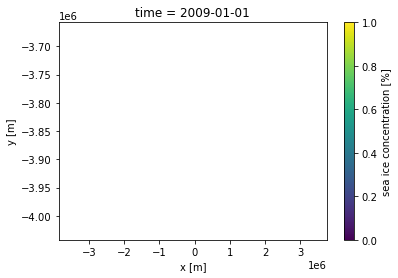

In [174]:
sic.plot()